In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# read a CSV into a dataframe (adjust filename as needed)
events_filename = './data/event.csv'  # or provide a full path

if not os.path.exists(events_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{events_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")

events = pd.read_csv(events_filename)
print(f"Loaded {len(events)} rows and {len(events.columns)} columns from {events_filename}")
events.head()

Loaded 107738 rows and 14 columns from ./data/event.csv


/var/folders/_b/sl_t4k5539781f29qf723b080000gn/T/ipykernel_52997/2221732598.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv(events_filename)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId
0,PITCH,False,False,True,徐若熙,蔣少宏,陳晨威,B,FF,145,71.11,-91.43,[],NaN
1,PITCH,True,True,False,徐若熙,蔣少宏,陳晨威,H,FF,147,54.86,42.67,"[{'type': 'PA', 'runnerName': '陳晨威', 'isOut': ...",NaN
2,PITCH,False,True,False,徐若熙,蔣少宏,林立,F,FF,145,54.86,22.35,[],NaN
3,PITCH,False,True,False,徐若熙,蔣少宏,林立,SW,SL,135,-2.03,-56.89,[],NaN
4,PITCH,False,False,True,徐若熙,蔣少宏,林立,B,SL,139,-34.54,-144.25,[],NaN


In [3]:
# read a CSV into a dataframe (adjust filename as needed)
pa_filename = './data/pa.csv'  # or provide a full path

if not os.path.exists(pa_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{pa_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")



pas = pd.read_csv(pa_filename, usecols=['inning', 'batterName', 'pitcherName', 'catcherName', 'pitchCodes', 'result', 'hardness', 'bases'])
print(f"Loaded {len(pas)} rows and {len(pas.columns)} columns from {pa_filename}")
pas.head()


Loaded 27600 rows and 8 columns from ./data/pa.csv


,inning,batterName,pitcherName,catcherName,bases,pitchCodes,result,hardness
0,1,陳晨威,徐若熙,蔣少宏,0,"['B', 'H']",GO,M
1,1,林立,徐若熙,蔣少宏,0,"['F', 'SW', 'B', 'B', 'S']",SO,NaN
2,1,梁家榮,徐若熙,蔣少宏,0,"['S', 'F', 'B', 'H']",2B,H
3,1,廖健富,徐若熙,蔣少宏,2,"['B', 'H']",1B,H
4,2,朱育賢,徐若熙,蔣少宏,0,"['S', 'SW', 'H']",FO,M


In [4]:
print(pas.shape)

(27600, 8)


# Calculate AVG, OPS, etc.

## filter out non-PITCH type

In [5]:
### filter out non-PITCH type
test_pas = pas[(pas['batterName'] == '林安可') & (pas['result'] != 'IGNORE')]

In [6]:
print(test_pas.shape)
test_pas.head()

(480, 8)


,inning,batterName,pitcherName,catcherName,bases,pitchCodes,result,hardness
149,2,林安可,施子謙,張肇元,0,"['B', 'SW', 'S', 'H']",FO,M
158,4,林安可,施子謙,張肇元,4,"['S', 'SW', 'B', 'H']",1B,H
167,5,林安可,楊達翔,張肇元,1,"['B', 'H']",GIDP,H
176,7,林安可,楊達翔,吳明鴻,3,"['B', 'B', 'B', 'B']",uBB,NaN
378,1,林安可,小野寺賢人,吳明鴻,0,"['S', 'S', 'B', 'F', 'B', 'SW']",SO,NaN


## cumulated avg, ops, etc. (at some point, not the final one)

In [7]:
# cumulative AVG / OPS over the plate appearances in test_pas
# Uses existing variables: test_pas, matplotlib.pyplot as plt, numpy as np, pandas as pd

# define result groups (keep consistent with earlier cells)
hits = {'1B', '2B', '3B', 'HR', 'IHR', 'H'}
bbs = {'uBB', 'IBB'}
hbps = {'HBP'}
non_ab_results = {'SH', 'SF', 'uBB', 'IBB', 'HBP', 'IH', 'IR', 'ID'}
tb_map = {'1B': 1, 'H': 1, '2B': 2, '3B': 3, 'HR': 4, 'IHR': 4}
_swing_tokens = {'SW', 'F', 'FT', 'FOUL_BUNT', 'TRY_BUNT', 'BUNT', 'H'}

def _count_items(codes):
    if pd.isna(codes):
        return 0
    if isinstance(codes, (list, tuple)):
        return len(codes)
    s = str(codes).strip()
    if s.startswith('[') and s.endswith(']'):
        inner = s[1:-1].strip()
        if inner == '':
            return 0
        parts = [p.strip() for p in inner.split(',') if p.strip() != '']
        return len(parts)
    return 1

def _count_sw(codes):
    if pd.isna(codes):
        return 0
    if isinstance(codes, (list, tuple)):
        return sum(1 for p in codes if str(p).strip().upper() == 'SW')
    s = str(codes).strip()
    if s.startswith('[') and s.endswith(']'):
        inner = s[1:-1].strip()
        if inner == '':
            return 0
        parts = [p.strip().strip("'\"").upper() for p in inner.split(',') if p.strip() != '']
        return sum(1 for p in parts if p == 'SW')
    return 1 if s.upper() == 'SW' else 0


def _count_sw(codes):
    if pd.isna(codes):
        return 0
    if isinstance(codes, (list, tuple)):
        return sum(1 for p in codes if str(p).strip().upper() == 'SW')
    s = str(codes).strip()
    if s.startswith('[') and s.endswith(']'):
        inner = s[1:-1].strip()
        if inner == '':
            return 0
        parts = [p.strip().strip("'\"").upper() for p in inner.split(',') if p.strip() != '']
        return sum(1 for p in parts if p == 'SW')
    return 1 if s.upper() == 'SW' else 0



def _count_swing(codes):
    if pd.isna(codes):
        return 0
    if isinstance(codes, (list, tuple)):
        return sum(1 for p in codes if str(p).strip().strip("'\"").upper() in _swing_tokens)
    s = str(codes).strip()
    if s.startswith('[') and s.endswith(']'):
        inner = s[1:-1].strip()
        if inner == '':
            return 0
        parts = [p.strip().strip("'\"").upper() for p in inner.split(',') if p.strip() != '']
        return sum(1 for p in parts if p in _swing_tokens)
    return 1 if s.strip().strip("'\"").upper() in _swing_tokens else 0


In [8]:
# compute per-player cumulative stats across plate appearances (uses existing variables: pas, hits, bbs, hbps,
# non_ab_results, tb_map, _count_sw, _count_swing, _count_swing/_count_swing_tokens etc.)
# result: pas_cum (per-PA cumulative time series) and bat_cum_final (final cumulative totals per batter)

# ensure pas is in chronological order (it should be); keep original index for alignment
_pas = pas.copy()

# helper to compute cumulative columns for one batter group
def _cum_for_group(g):
    # preserve original index
    idx = g.index

    # compute cumulative counts *before* the current PA (shift the cumsum)
    cum_ab = (~g['result'].isin(non_ab_results)).astype(int).cumsum().shift(1).fillna(0).astype(int)
    cum_non_ab = g['result'].isin(non_ab_results).astype(int).cumsum().shift(1).fillna(0).astype(int)
    cum_hits = g['result'].isin(hits).astype(int).cumsum().shift(1).fillna(0).astype(int)
    cum_BB = g['result'].isin(bbs).astype(int).cumsum().shift(1).fillna(0).astype(int)
    cum_HBP = g['result'].isin(hbps).astype(int).cumsum().shift(1).fillna(0).astype(int)
    cum_TB = g['result'].map(tb_map).fillna(0).astype(int).cumsum().shift(1).fillna(0).astype(int)
    cum_PA = cum_ab + cum_non_ab

    # cumulative rates (based on values before this PA)
    AVG = cum_hits / cum_ab.replace({0: np.nan})
    OBP = (cum_hits + cum_BB + cum_HBP) / cum_PA.replace({0: np.nan})
    SLG = cum_TB / cum_ab.replace({0: np.nan})
    OPS = OBP + SLG

    # replace NaNs from division-by-zero with 0 so early PAs show 0
    AVG = AVG.fillna(0)
    OBP = OBP.fillna(0)
    SLG = SLG.fillna(0)
    OPS = OPS.fillna(0)

    # sw / swings cumulative BEFORE the PA
    sw_counts = g['pitchCodes'].apply(_count_sw).cumsum().shift(1).fillna(0).astype(int)
    swing_counts = g['pitchCodes'].apply(_count_swing).cumsum().shift(1).fillna(0).astype(int)
    whiff = sw_counts / swing_counts.replace({0: np.nan})
    whiff = whiff.fillna(0)

    out = pd.DataFrame({
        'batterName': g['batterName'],
        'AB': cum_ab,
        'PA': cum_PA,
        'H': cum_hits,
        'BB': cum_BB,
        # 'cum_HBP': cum_HBP,
        # 'cum_TB': cum_TB,
        # 'cum_SW': sw_counts,
        # 'cum_SWINGS': swing_counts,
        'AVG': AVG,
        'OBP': OBP,
        'SLG': SLG,
        'OPS': OPS,
        'whiff': whiff
    }, index=idx)
    return out

# run groupby and compute cumulative series for each batter
groups = [_cum_for_group(g) for _, g in _pas.groupby('batterName', sort=False)]
pas_cum = pd.concat(groups).sort_index()
display(pas_cum.head(10))

# final cumulative stats per batter (last PA for each batter)
bat_cum_final = pas_cum.groupby('batterName', sort=True).last().reset_index()


,batterName,AB,PA,H,BB,AVG,OBP,SLG,OPS,whiff
0,陳晨威,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,林立,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,梁家榮,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,廖健富,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,朱育賢,0,0,0,0,0.0,0.0,0.0,0.0,0.0
5,林承飛,0,0,0,0,0.0,0.0,0.0,0.0,0.0
6,邱丹,0,0,0,0,0.0,0.0,0.0,0.0,0.0
7,嚴宏鈞,0,0,0,0,0.0,0.0,0.0,0.0,0.0
8,林禹叡,0,0,0,0,0.0,0.0,0.0,0.0,0.0
9,陳晨威,1,1,0,0,0.0,0.0,0.0,0.0,0.0


,batterName,AB,PA,H,BB,AVG,OBP,SLG,OPS,whiff
63,林安可,410,479,105,60,0.256098,0.350731,0.458537,0.809267,0.23821


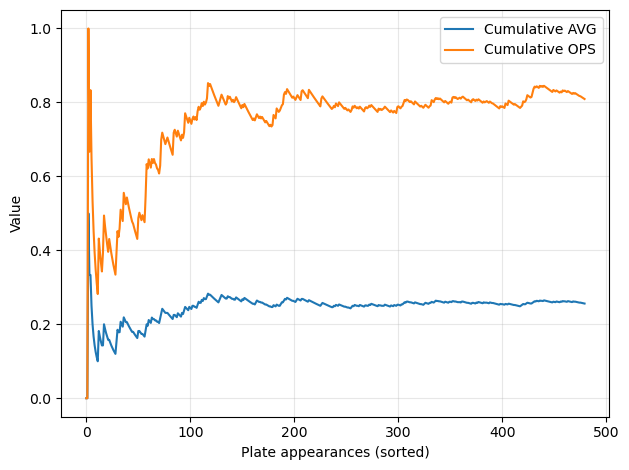

In [9]:
test_bat_cum_final = bat_cum_final[bat_cum_final['batterName'] == '林安可']
display(test_bat_cum_final.head())

test_bat_stats = pas_cum[pas_cum['batterName'] == '林安可']
plt.plot(test_bat_stats['PA'], test_bat_stats['AVG'], label='Cumulative AVG')
plt.plot(test_bat_stats['PA'], test_bat_stats['OPS'], label='Cumulative OPS')
plt.xlabel('Plate appearances (sorted)')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# write new files

In [10]:
# combine pas and pas_cum and write to csv
# uses existing variables: pas, pas_cum, os, pd

out_path = './data/pa_with_stats.csv'

# align on row order/index; drop duplicate batterName from pas_cum
pas_cum_cols = [c for c in pas_cum.columns if c != 'batterName']

if pas.index.equals(pas_cum.index):
    combined = pd.concat([pas, pas_cum[pas_cum_cols]], axis=1)
else:
    # fallback: align by reset_index (preserve row order)
    combined = pd.concat([pas.reset_index(drop=True), pas_cum[pas_cum_cols].reset_index(drop=True)], axis=1)

# ensure output directory exists
out_dir = os.path.dirname(out_path)
if out_dir:
    os.makedirs(out_dir, exist_ok=True)

# write with UTF-8-SIG so Excel handles Chinese characters correctly
combined.to_csv(out_path, index=False, encoding='utf-8-sig')

print(f"Wrote combined dataframe with {len(combined)} rows to: {out_path}")

Wrote combined dataframe with 27600 rows to: ./data/pa_with_stats.csv
